## Fourier Neural Operator

Add some description

paper: https://arxiv.org/abs/2010.08895

In [52]:
# external imports
import torch
from torch.utils.data import DataLoader
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt

# continuity imports
from continuity.trainer import Trainer
from continuity.data import OperatorDataset
from continuity.operators.fourier_neural_operator import FourierLayer

In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1D Dataset

In [54]:
# Input function
u = lambda chi: torch.cos(chi)
u = lambda chi: torch.exp(-chi**2)*10

# Target function
v = lambda chi: torch.sin(chi)
v = lambda chi: torch.exp(-chi**2)*2*10 * (-chi)

# Domain parameters
L = torch.pi * 2
N = 1000
xi = torch.arange(-N/2, N/2) / N * L  # from the same domain as y and x to plot "continuous" representations of u and v

num_sensors = 31
num_evaluations = 31
x = (torch.arange(-num_sensors/2, num_sensors/2) / num_sensors * L ).to(device)
y = (torch.arange(-num_evaluations/2, num_evaluations/2) / num_evaluations * L).to(device)

# This dataset contains only a single sample (first dimension of all tensors)
n_observations = 1
u_dim = x_dim = y_dim = v_dim = 1
dataset = OperatorDataset(
    x=x.reshape(n_observations, num_sensors, x_dim),
    u=u(x).reshape(n_observations, num_sensors, u_dim),
    y=y.reshape(n_observations, num_evaluations, y_dim),
    v=v(y).reshape(n_observations, num_evaluations, v_dim)
)
data_loader = DataLoader(dataset)

## Operator

In [69]:
# Single FNO layer
model = FourierLayer(dataset.shapes)

## Before Training

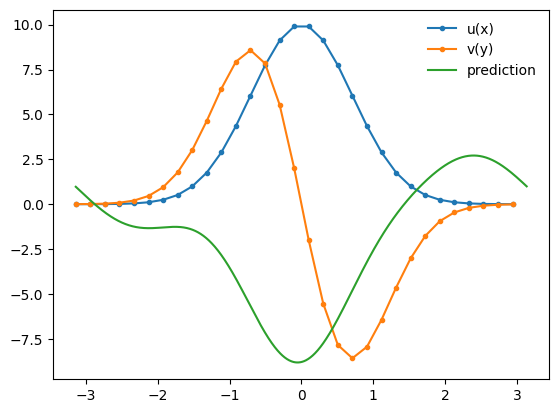

In [56]:
x_i, u_i, y_i, v_i = dataset[:] 
y_plot = xi.reshape(n_observations, -1, y_dim)
u_plot = u(y_plot)
v_pred = model(x_i, u_i, y_plot).squeeze()

plt.plot(x_i.squeeze(), u_i.squeeze(), marker=".", label="u(x)")
plt.plot(y_i.squeeze(), v_i.squeeze(), marker=".", label="v(y)")
plt.plot(y_plot.squeeze(), v_pred.squeeze().detach(), label="prediction")
plt.legend(frameon=False)

## Training

In [70]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
trainer = Trainer(model, device=device, optimizer=optimizer)

In [71]:
trainer.fit(dataset, epochs=30000)

Model parameters: 16
Device: cpu
Epoch 30000:  loss/train = 1.0856e-02  (0.000 s/epoch)


In [59]:
# compute prediction and reshape
x_i, u_i, y_i, v_i = dataset[:] 
y_plot = xi.reshape(n_observations, -1, y_dim)
u_plot = u(y_plot)

v_pred = model(x_i, u_i, y_plot).squeeze()

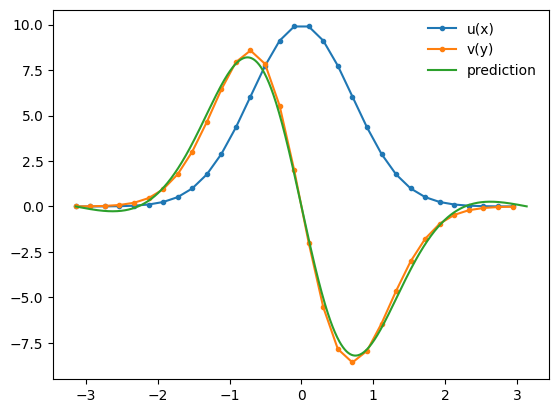

In [60]:
plt.plot(x_i.squeeze(), u_i.squeeze(), marker=".", label="u(x)")
plt.plot(y_i.squeeze(), v_i.squeeze(), marker=".", label="v(y)")
plt.plot(y_plot.squeeze(), v_pred.squeeze().detach(), label="prediction")
plt.legend(frameon=False)

### Changing the dimensionality of $u$

The FourierLayer allows you to change the number of evaluation points of $y$ for each forward pass. In the same way the dimensionality of parameter $u$ can also be changed. In the case of $u$ being larger than what was specified during initialization, the Fourier Layer removes the high frequencies. In case $u$ is smaller, zero-values large fequencies are added.

In [61]:
# compute prediction and reshape
x_i, u_i, y_i, v_i = dataset[:] 
y_plot = xi.reshape(n_observations, -1, y_dim)
u_plot = u(y_plot)

v_pred = model(x_i, u_plot, y_plot).squeeze()

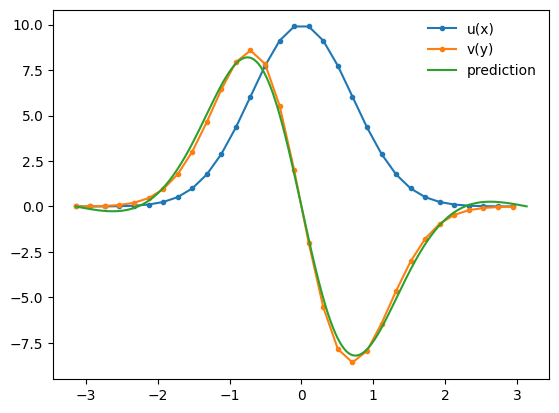

In [62]:
plt.plot(x_i.squeeze(), u_i.squeeze(), marker=".", label="u(x)")
plt.plot(y_i.squeeze(), v_i.squeeze(), marker=".", label="v(y)")
plt.plot(y_plot.squeeze(), v_pred.squeeze().detach(), label="prediction")
plt.legend(frameon=False)

## Reducing the number of modes

In [105]:
modes1, modes2, modes3 = 10, 4, 3
model1 = FourierLayer(dataset.shapes, num_modes=(modes1,))
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)
trainer1 = Trainer(model1, device=device, optimizer=optimizer1)

model2 = FourierLayer(dataset.shapes, num_modes=(modes2,))
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
trainer2 = Trainer(model2, device=device, optimizer=optimizer2)

model3 = FourierLayer(dataset.shapes, num_modes=(modes3,))
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001)
trainer3 = Trainer(model3, device=device, optimizer=optimizer3)

In [106]:
trainer1.fit(dataset, epochs=10000)
trainer2.fit(dataset, epochs=10000)
trainer3.fit(dataset, epochs=10000)

Model parameters: 6
Device: cpu
Epoch 8013:  loss/train = 9.9985e-06  (0.000 s/epoch)
Model parameters: 3
Device: cpu
Epoch 10000:  loss/train = 1.6783e+00  (0.000 s/epoch)
Model parameters: 2
Device: cpu
Epoch 10000:  loss/train = 1.0294e+01  (0.000 s/epoch)


In [107]:
u_plot = u(y_plot)
v_pred1 = model1(x_i, u_i, y_plot).squeeze()
v_pred2 = model2(x_i, u_i, y_plot).squeeze()
v_pred3 = model3(x_i, u_i, y_plot).squeeze()

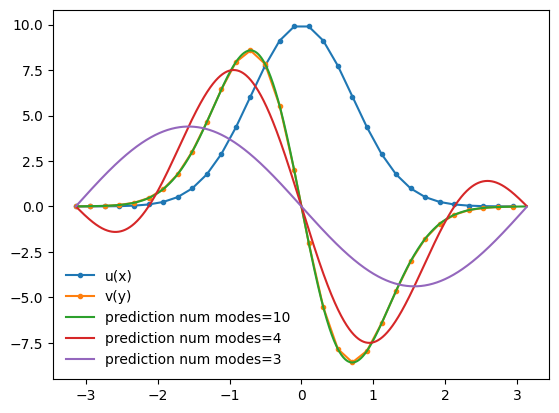

In [108]:
plt.plot(x_i.squeeze(), u_i.squeeze(), marker=".", label="u(x)")
plt.plot(y_i.squeeze(), v_i.squeeze(), marker=".", label="v(y)")
plt.plot(y_plot.squeeze(), v_pred1.squeeze().detach(), label=f"prediction num modes={modes1}")
plt.plot(y_plot.squeeze(), v_pred2.squeeze().detach(), label=f"prediction num modes={modes2}")
plt.plot(y_plot.squeeze(), v_pred3.squeeze().detach(), label=f"prediction num modes={modes3}")
plt.legend(frameon=False)

## Visualize the Fourier transformed functions

Text(0.5, 0, 'Img(v-fourier)')

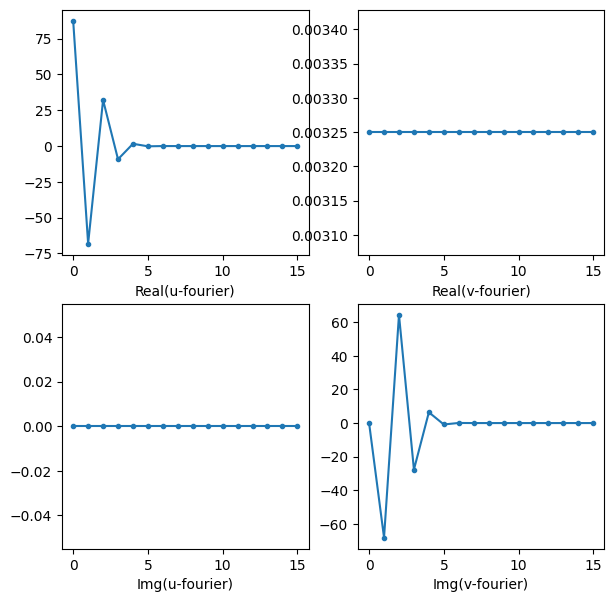

In [109]:
# Fourier transform of input and target function
u_fourier = torch.fft.rfft(u_i, dim=1)
v_fourier = torch.fft.rfft(v_i, dim=1)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[7, 7])

frequencies = range(0, len(u_fourier.squeeze()), 1)
ax1.plot(frequencies, u_fourier.squeeze().real, marker=".", label="u(x)")
ax1.set_xlabel("Real(u-fourier)")

ax3.plot(frequencies, u_fourier.squeeze().imag, marker=".", label="u(x)")
ax3.set_xlabel("Img(u-fourier)")

ax2.plot(frequencies, v_fourier.squeeze().real, marker=".", label="v(x)")
ax2.set_xlabel("Real(v-fourier)")

ax4.plot(frequencies, v_fourier.squeeze().imag, marker=".", label="v(x)")
ax4.set_xlabel("Img(v-fourier)")

## 2D Dataset

In [111]:
def multivariate_normal_2d(input_tensor: torch.Tensor, loc: int = 0., scale: float = 1.) -> torch.Tensor:
    """ Multivariate normal 2 dimensional distribution.

    Args:
        input_tensor: input with shape = (num_evaluations, 2)
        loc: Mean of normal dist
        scale: standard deviation of normal dist
    Returns:
        Tensor with shape = (num_evaluations)
    """

    distribution = MultivariateNormal(torch.ones(2) * loc, scale * torch.eye(2))
    value = torch.exp(distribution.log_prob(input_tensor))
    return value

def double_multivariate_normal_2d(input_tensor: torch.Tensor) -> torch.Tensor:
    """ Two Multivariate normal distributions with mean values at:
        * loc1 = (1, 1)
        # loc2 = (-1, -1)
    And standard deviation: 0.5

    Args:
        input_tensor: input with shape = (num_evaluations, 2)
    Returns:
        Tensor with shape = (num_evaluations)
    """

    #return input_tensor[:, 1] * input_tensor[:, 0] / 20
    return multivariate_normal_2d(input_tensor, 1, 0.5) + multivariate_normal_2d(input_tensor, -1, 0.5)

In [112]:

# define grid and flatten
N =51
x = torch.arange(-N/2, N/2) / N * 6
y = torch.arange(-N/2, N/2) / N * 6
xx, yy = torch.meshgrid(x, y)
input_tensor = torch.stack([xx.flatten(), yy.flatten()], axis=1)

# evaluate on grid
u = multivariate_normal_2d(input_tensor)
v = double_multivariate_normal_2d(input_tensor)

# reshape into grid
u_reshaped = u.reshape(N, N)
v_reshaped = v.reshape(N, N)

/Users/michelluchmann/Projects/Continuity/continuity/venv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [113]:
# define finer grid
N2 = 1000
x_fine = torch.arange(-N2/2, N2/2) / N2 * 6
y_fine = torch.arange(-N2/2, N2/2) / N2 * 6
xx_fine, yy_fine = torch.meshgrid(x_fine, y_fine)
input_tensor_fine = torch.stack([xx_fine.flatten(), yy_fine.flatten()], axis=1)

# evaluate on grid
u_fine = multivariate_normal_2d(input_tensor_fine).reshape(N2, N2)
v_fine = double_multivariate_normal_2d(input_tensor_fine).reshape(N2, N2)

# reshape into grid
u_reshaped_fine = u_fine.reshape(1, -1, 1)
v_reshaped_fine = v_fine.reshape(1, -1, 1)
x_reshaped_fine = torch.stack([xx_fine.flatten(), yy_fine.flatten()], axis=-1).unsqueeze(0)

Text(0.5, 1.0, 'Target function v(x) fine resolution')

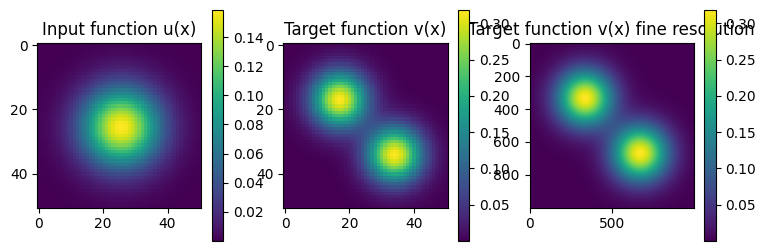

In [114]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[9, 3])

img = ax1.imshow(u_reshaped)
fig.colorbar(img)
ax1.set_title("Input function u(x)")

img = ax2.imshow(v_reshaped)
fig.colorbar(img)
ax2.set_title("Target function v(x)")

img = ax3.imshow(v_reshaped_fine.reshape(N2, N2))
fig.colorbar(img)
ax3.set_title("Target function v(x) fine resolution")


In [115]:
x_reshaped = torch.stack([xx.flatten(), yy.flatten()], axis=-1).unsqueeze(0)
u_reshaped = u.reshape(1, -1, 1)
v_reshaped = v.reshape(1, -1, 1)

In [116]:
dataset_2d = OperatorDataset(
    x_reshaped,
    u_reshaped,
    x_reshaped,
    v_reshaped,
)

shapes = dataset_2d.shapes
data_loader_2d = DataLoader(dataset_2d)

In [117]:
model = FourierLayer(shapes=shapes)

In [118]:
x_i, u_i, y_i, v_i = dataset_2d[:]
v_pred_before = model(x_i, u_i, y_i)

batch_idx = 0
u_i_reshaped = u_i[batch_idx].reshape(N, N)
v_i_reshaped = v_i[batch_idx].reshape(N, N)
v_pred_reshaped = v_pred_before[batch_idx].reshape(N, N)

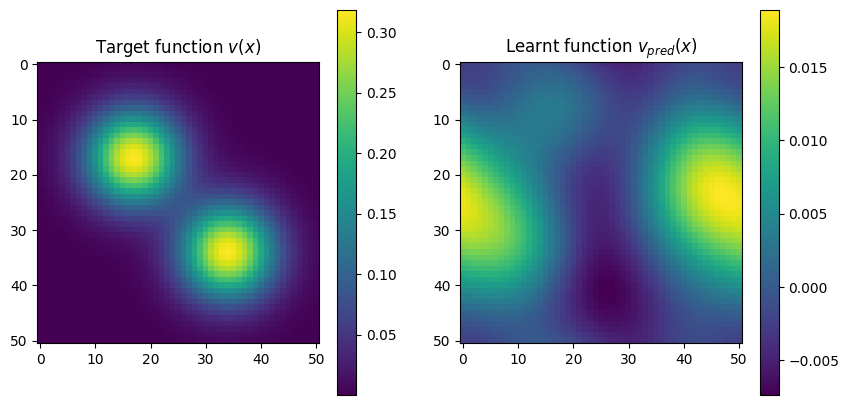

In [119]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 5])

img = ax1.imshow(v_i_reshaped.detach())
ax1.set_title(r'Target function $v(x)$')
fig.colorbar(img)

img2 = ax2.imshow(v_pred_reshaped.detach())
ax2.set_title(r'Learnt function $v_{pred}(x)$')
fig.colorbar(img2)

In [120]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = Trainer(model, device=device, optimizer=optimizer)

In [121]:
trainer.fit(dataset_2d, epochs=10000)

Model parameters: 1326
Device: cpu
Epoch 10000:  loss/train = 4.9902e-05  (0.000 s/epoch)


In [125]:
# evaluate prediction
y_plot = x_reshaped_fine
v_pred = model(x_i, u_reshaped, y_plot)
v_pred_reshaped = v_pred[batch_idx].reshape(N2, N2)

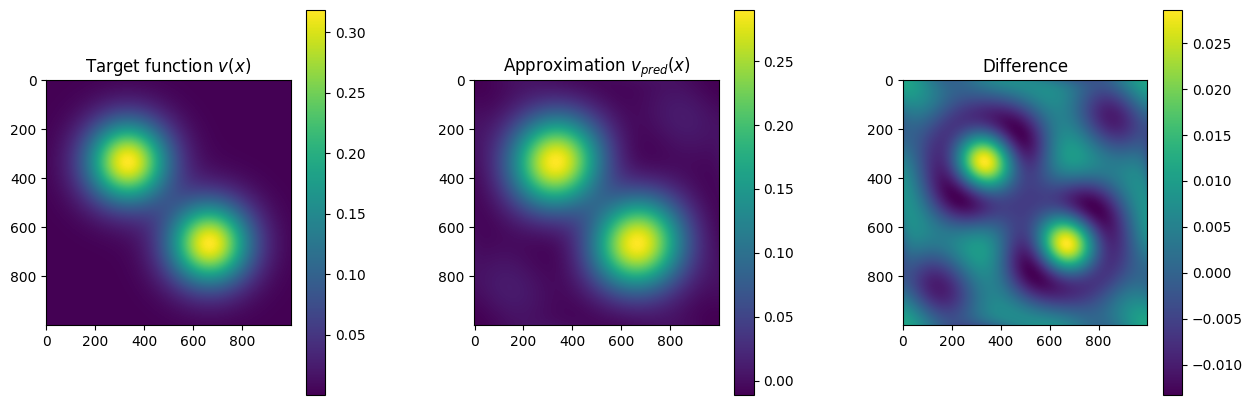

In [128]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[15, 5], )

img = ax1.imshow(v_reshaped_fine.detach().reshape(N2, N2))
fig.colorbar(img)
ax1.set_title(r"Target function $v(x)$")

img2 = ax2.imshow(v_pred_reshaped.detach().reshape(N2, N2))
fig.colorbar(img2)
ax2.set_title(r"Approximation $v_{pred}(x)$")

img3 = ax3.imshow(v_reshaped_fine.detach().reshape(N2, N2) - v_pred_reshaped.detach())
fig.colorbar(img3)
ax3.set_title("Difference")

fig.subplots_adjust(wspace=0.4)